# Avocado Dataset

In this notebook, I will explore a dataset provided by the Hass Avocado board website. The dataset can be found here: https://www.kaggle.com/neuromusic/avocado-prices/data

My goal here is to predict the average price of avocados, using four different methods.

## Section 1 - Import Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
import datetime
import scipy.stats
import pmdarima as pmd
from collections import Counter
from fbprophet import Prophet
from pylab import boxplot
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

Importing plotly failed. Interactive plots will not work.
Using TensorFlow backend.


## Section 2 - Explore and Clean the dataset

First, I will explore the dataset and some of the key fields.

In [2]:
data = pd.read_csv('avocado.csv')
print(f"The data has {data.shape[0]} rows and {data.shape[1]} columns")

The data has 18249 rows and 14 columns


In [3]:
data.head(5)

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


#### Date and Year

The date field is important for this analysis. First, I will convert it into a proper datetime (instead of a string). Then I will check the distribution. 

In [4]:
# convert the date column to a date
data['Date'] = data['Date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date())
data = data.sort_values(by=['type', 'region', 'Date'])

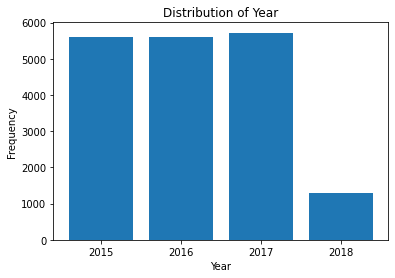

In [5]:
year_counts = data['year'].value_counts()
all_years = range(min(data['Date']).year, max(data['Date']).year+1)

plt.bar(year_counts.index, year_counts)
plt.title('Distribution of Year')
plt.ylabel('Frequency')
plt.xlabel('Year')
plt.xticks(range(min(data['year']), math.ceil(max(data['year']))+1))
plt.show()

#### Region 

The `Region` field seems to be a mish-mash of values: some are cities, some are states, some are regions, and some are countries.

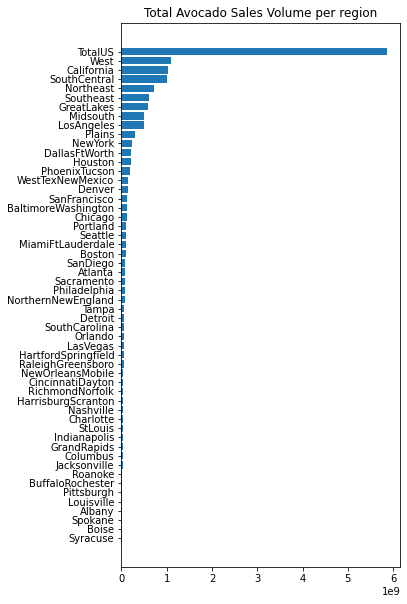

In [6]:
region_totals = data.groupby('region')['Total Volume'].sum()
region_totals = region_totals.sort_values()
plt.figure(figsize=(5,10))
plt.barh(region_totals.index, region_totals)
plt.title('Total Avocado Sales Volume per region')
plt.xticks()
plt.show()

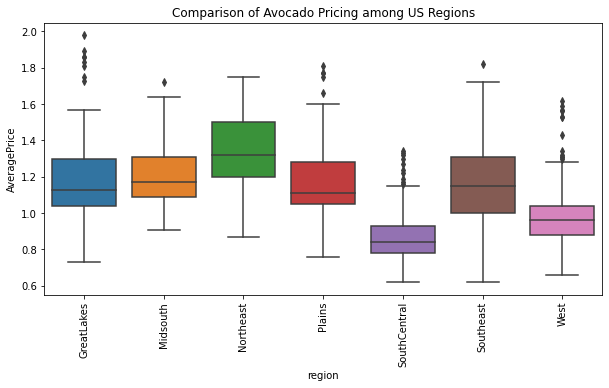

In [7]:
# comparison
plt.figure(figsize=(10,5))
top_regions = ['West', 'SouthCentral', 'Northeast', 'Southeast', 'GreatLakes', 'Midsouth', 'Plains']
top_region_data = data[data['region'].isin(top_regions)]

top_conv = top_region_data[top_region_data['type']=='conventional']
sns.boxplot(y='AveragePrice', x='region', data=top_conv)

plt.title('Comparison of Avocado Pricing among US Regions')
plt.xticks(rotation=90)
plt.show()

Since this is a time-series analysis, I need to focus on only one region. Since California is well-known for avocado production and has a large sales volume compared to the other regions, I will focus on that.

In [8]:
cali_data = data[data['region']=='California'].reset_index(drop=True)
print(f'For California, there are {cali_data.shape[0]} rows.')

For California, there are 338 rows.


#### Type

In the dataset, avocados are divided into two types - conventional and organic.

In [9]:
print(Counter(cali_data['type']))

Counter({'conventional': 169, 'organic': 169})


In [10]:
organic = cali_data[cali_data['type']=='organic']
convention = cali_data[cali_data['type']=='conventional']

Shown below are a comparison of total sales volume and average avocado price for conventional and organic avocados.

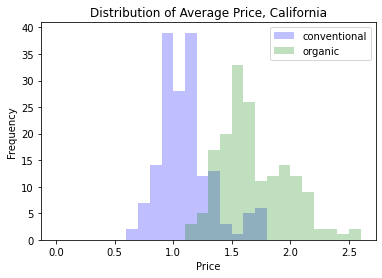

In [12]:
binsize = 0.1
histbins = np.arange(0, max(cali_data['AveragePrice'])+binsize, binsize)

# average price histogram
ax = plt.axis()

plt.hist(convention['AveragePrice'], bins=histbins, color='blue', alpha=0.25, label='conventional')
plt.hist(organic['AveragePrice'], bins=histbins, color='green', alpha=0.25, label='organic')
plt.legend()
plt.title('Distribution of Average Price, California')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.show()

#### Seasonal trends

I want to determine if there are any seasonal trends in avocado pricing or sales. In the two plots below, the pink regions indicate summer months and the blue regions indicate winter.

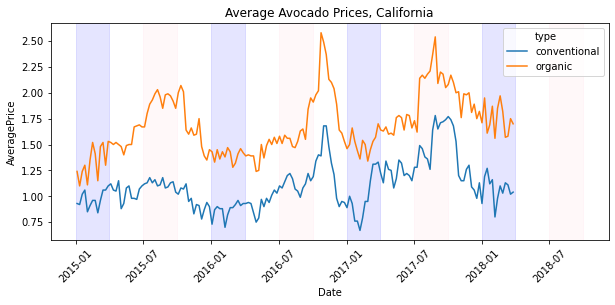

In [13]:
# plot Average Price

fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot(x='Date', y='AveragePrice', data=cali_data, hue=cali_data['type'])
plt.title('Average Avocado Prices, California')

for year in all_years:
    ax.axvspan(datetime.date(year,1,1), datetime.date(year,3,31), alpha=0.1, color='blue')
    ax.axvspan(datetime.date(year,7,1), datetime.date(year,9,30), alpha=0.1, color='pink')

plt.xticks(rotation=45)
plt.show()

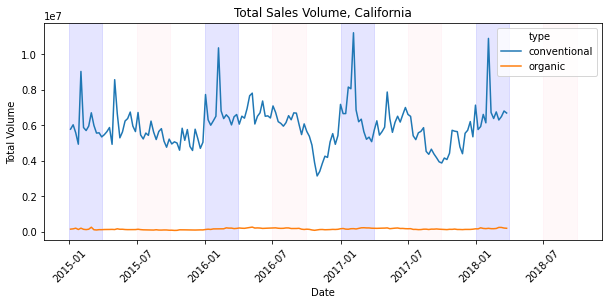

In [14]:
# plot Total Volume

fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot(x='Date', y='Total Volume', data=cali_data, hue=cali_data['type'])
plt.title('Total Sales Volume, California')

for year in all_years:
    ax.axvspan(datetime.date(year,1,1), datetime.date(year,3,31), alpha=0.1, color='blue')
    ax.axvspan(datetime.date(year,7,1), datetime.date(year,9,30), alpha=0.1, color='pink')

plt.xticks(rotation=45)
plt.show()

A few conclusions can be made:
- although sales volumes are much smaller for organic avocados, they are priced more expensive.
- sales volume tends to decrease during the summer months
- avocado prices increase in the winter and decrease in the summer -- this probably has to do with the greater availability in the summer and higher demand in the winter.

I will focus on conventional avocados in this analysis.

In [16]:
cali_data=cali_data[cali_data['type']=='conventional'].reset_index(drop=True)

#### Volume fields

There are several fields in the dataset that reference sales volumes. They can be divided into single-avocado, bagged avocado, and total sales volumes. The results are shown in the plots below.

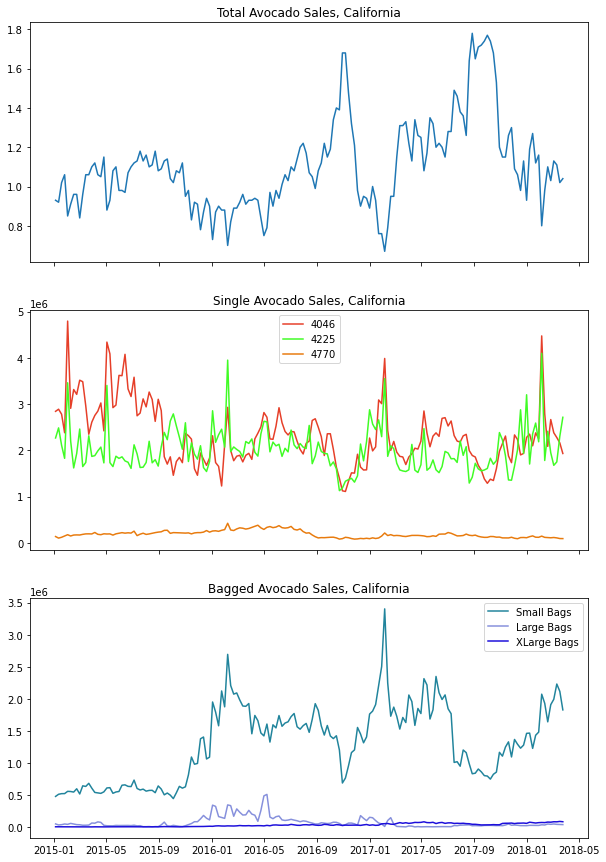

In [17]:
fig, ax = plt.subplots(3,1, figsize=(10,15), sharex=True)

ax[0].plot(cali_data['Date'], cali_data['AveragePrice'])
ax[0].set_title('Total Avocado Sales, California')

# single
for col in ['4046', '4225', '4770']:
    random_colour = tuple(np.random.uniform(0,1, size=3))
    ax[1].plot(cali_data['Date'], cali_data[col], label=col, color=random_colour)
ax[1].legend()
ax[1].set_title('Single Avocado Sales, California')

# bagged
for col in ['Small Bags', 'Large Bags', 'XLarge Bags']:
    random_colour = tuple(np.random.uniform(0,1, size=3))
    ax[2].plot(cali_data['Date'], cali_data[col], label=col, color=random_colour)
ax[2].legend()
ax[2].set_title('Bagged Avocado Sales, California')

plt.show()

Some conclusions about avocado sales volumes:
- more sales come from single avocados than bagegd avocados
- codes 4046 and 4225 make up around the same amount of sales, while 4770 has much smaller sales volume
- smaller bags have the greatest sales while extra large bags have the smallest

## Section 3 - Forecasting

In this section, I will explore and compare different forcasting methods to predict the average avocado price. To comapre methods, I will plot the results and calculate the MSE.

#### Train/test split

First, I'll set a cut-off date to differentiate between the training and test set. For the test set, assume it is in the future and no values are provided within this range of dates.

In [21]:
CUTOFF_DATE = datetime.date(2017,6,4)
FINAL_DATE = datetime.date(2018,12,31)

train_data = cali_data[cali_data['Date']<CUTOFF_DATE].reset_index(drop=True)
test_data = cali_data[cali_data['Date']>=CUTOFF_DATE]

all_data = pd.concat([train_data, test_data], sort=True)

In [24]:
print('\t\tMin Date\t Max Date')
print('Train data: \t', min(train_data['Date']), '\t', max(train_data['Date']))
print('Test data: \t', min(test_data['Date']), '\t', max(test_data['Date']))

		Min Date	 Max Date
Train data: 	 2015-01-04 	 2017-05-28
Test data: 	 2017-06-04 	 2018-03-25


#### Visualize the Train and test sets

The following chart shows the data being used. The shaded blue region is the test set, for which I will make predictions and calculate the MSE.

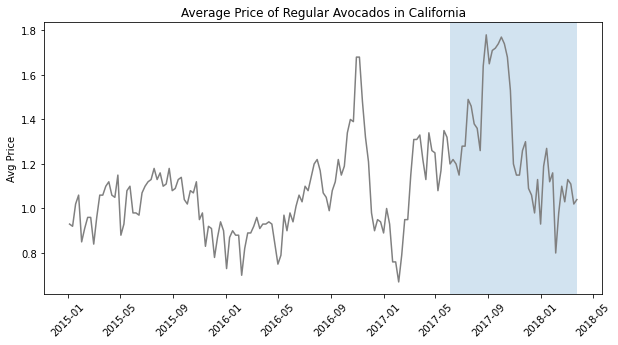

In [25]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(cali_data['Date'], cali_data['AveragePrice'], color='grey')
plt.title('Average Price of Regular Avocados in California')
plt.ylabel('Avg Price')
ax.axvspan(CUTOFF_DATE, max(cali_data['Date']), alpha=0.2)
plt.xticks(rotation=45)
plt.show()

In [26]:
train_mse_comparison = {}
test_mse_comparison = {}

### Method 1 - Naiive Approaches

I will start by examining two simple approaches: moving average and moving average rate of change.

#### Moving Average

The moving average predictor will take average of the previous `N` vaues, and use that as the next prediction. My expectation is that this will work well for the one-month-ahead pridictions (in the training set), but will not work well for the test set.

I could spend some time fine-tuning the `N` parameter, but since this method won't give great results in any case, I will leave it fixed. I will choose `N=3`.

#### Moving Average Rate of Change

With this method, we can look at the average rate of change between the previous `N` observations to get the next rate of change. This value is then multiplied by the previous observation to get the valye of the new observation.

Again, since this is a relatively naiive approach, we shouldn't expect this to do well on future predictions, so we can leave `N` fixed to get a quick idea of what's going on.

In [27]:
class MovingAvgPredictor():
    
    def __init__(self, n):
        self.n = n
        
        self.train_y = []
        self.train_ts = []
        
        self.train_predictions = []
        self.test_predictions = []
        
        
    def fit(self, x_train, y_train):
        
        self.train_y = list(y_train[-self.n:])
        self.train_ts = list(x_train[self.n:])
        
        # predict on train set 
        self.train_predictions = []
        for i in range(self.n, len(x_train)):
            self.train_predictions.append(sum(y_train[i-self.n:i])/self.n)
        
    
    def predict(self, x_test):
        
        if len(self.train_predictions) == 0:
            raise AssertionError("You need to fit first")
        
        prev_vals = self.train_y
        
        # predict future values
        self.test_predictions = []
        for i in range(len(x_test)):
            new_prediction = sum(prev_vals[-self.n:])/self.n
            self.test_predictions.append(new_prediction)
            prev_vals.append(new_prediction)   
        
        test_result = pd.DataFrame({'ts': x_test, 'y': self.test_predictions})

        return test_result


In [28]:
class RateOfChangePredictor():
    
    def __init__(self, n):
        self.n = n
        
        self.train_y = []
        self.train_ts = []
        
        self.rates_of_change = []
        
        self.train_predictions = []
        self.test_predictions = []
        
        
    def fit(self, x_train, y_train):
        
        self.train_y = list(y_train[self.n:])
        self.train_ts = list(x_train[self.n:])
        
        self.rates_of_change = [(self.train_y[i]-self.train_y[i-1])/self.train_y[i-1] for i in range(1, len(self.train_y))]
        
        # predict on train set 
        self.train_predictions = []
        for i in range(self.n+1, len(self.train_y)):
            avg_roc = np.mean(self.rates_of_change[i-self.n:i])
            prev_ts = self.train_y[i-self.n]
            self.train_predictions.append(prev_ts*(1+avg_roc))
            
    
    def predict(self, x_test):
        
        if len(self.train_predictions) == 0:
            raise AssertionError("You need to fit first")
        
        prev_n_vals = self.train_y[-self.n:]
        last_n_roc = self.rates_of_change[-self.n+1:]
        
        # predict future values
        self.test_predictions = []
        
        for i in range(len(x_test)):
            
            # the new rate of change is avg  of last (n-1)
            new_rate_of_change = sum(last_n_roc)/(self.n-1)
            new_prediction = prev_n_vals[-1]*(1+new_rate_of_change)
            
            self.test_predictions.append(new_prediction)
            prev_n_vals.append(new_prediction)
            prev_n_vals.pop(0)
            
            last_n_roc.append(new_rate_of_change)
            last_n_roc.pop(0)
        
        test_result = pd.DataFrame({'ts': x_test, 'y': self.test_predictions})
        
        return test_result



#### Predict

In [29]:
N = 3

In [30]:
ma_predictor = MovingAvgPredictor(N)
ma_predictor.fit(train_data['Date'], train_data['AveragePrice'])
    
ma_train_results = pd.DataFrame({'ts': ma_predictor.train_ts, 'y': ma_predictor.train_predictions})
ma_test_results = ma_predictor.predict(test_data['Date'])
ma_results = pd.concat([ma_train_results, ma_test_results])

train_mse_comparison['Moving Average'] = round(mean_squared_error(train_data['AveragePrice'][N:], ma_train_results['y']),4)
test_mse_comparison['Moving Average'] = round(mean_squared_error(test_data['AveragePrice'], ma_test_results['y']),4)

In [31]:
roc_predictor = RateOfChangePredictor(N)
roc_predictor.fit(train_data['Date'], train_data['AveragePrice'])

roc_train_result = pd.DataFrame({'ts': roc_predictor.train_ts[N+1:], 'y': roc_predictor.train_predictions})
roc_test_result = roc_predictor.predict(test_data['Date'])
roc_results = pd.concat([roc_train_result, roc_test_result])

train_mse_comparison['Moving Average Rate of Change'] = round(mean_squared_error(train_data['AveragePrice'][2*N+1:], roc_train_result['y']),4)
test_mse_comparison['Moving Average Rate of Change'] = round(mean_squared_error(test_data['AveragePrice'], roc_test_result['y']),4)

#### Results

Both models are able to predict the next value in the sequence fairly well, but after a few timesteps, they fall apart. This approach might be okay for predicting the next timestep, but should not be used for predictions weeks in advance.

The moving average will converge to a constant value (depending on the previous N values). The Moving average rate of change, on the other hand, will explode.

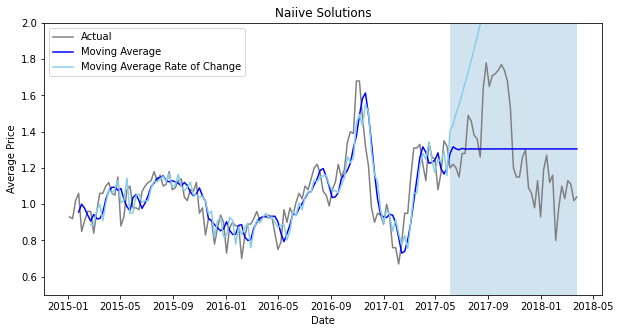

In [32]:
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(cali_data['Date'], cali_data['AveragePrice'], color='grey', label='Actual')
plt.plot(ma_results['ts'], ma_results['y'], label='Moving Average', color='blue')    
plt.plot(roc_results['ts'], roc_results['y'], label='Moving Average Rate of Change', color='skyblue')    

plt.title('Naiive Solutions')
plt.xlabel('Date')
plt.ylim(0.5,2)
plt.ylabel('Average Price')
plt.legend()
ax.axvspan(CUTOFF_DATE, max(cali_data['Date']), alpha=0.2)
plt.show()

### Method 2 - ARIMA / SARIMA

ARIMA models (and its variations) are used for forcasting, using only timeseries data. They create a linear regression model using previous observations (aka, its "lag")
- A model with lag = 1 is called a univariate model
- A model with lag > 1 is called a multivariate model

The simplest of these models is ARIMA (autoregressive integrated moving average model). Building on this is SARIMA (seasonal ARIMA), which takes into account seasonal changes. 

#### ARIMA

I will start with the simpler option, ARIMA. The ARIMA function takes three parameters:
- `d` - the degree of differencing, aka, the number of times observations are differenced
- `p` - the lag order, aka, the number of lag observations included in the model
- `q` - the order of moving average, aka, the size of the moving average window

In [33]:
# format the data
arima_data = train_data.set_index('Date')[['AveragePrice']]
arima_data.head()

,AveragePrice
Date,
2015-01-04,0.93
2015-01-11,0.92
2015-01-18,1.02
2015-01-25,1.06
2015-02-01,0.85


#### d - degree of differencing

Since ARIMA is really a linear regression model, it has the underlying assumption that features are independent and uncorrelated. Therefore, the data needs to be stationary. The easiest approach is to difference it (subtract the previous value from the current value). The parameter that controls the degree of differencing is `d`.

The autocorrelation plot below shows the autocorrelation function (ACF) for each lag step, for both the original data and the first order differencing.

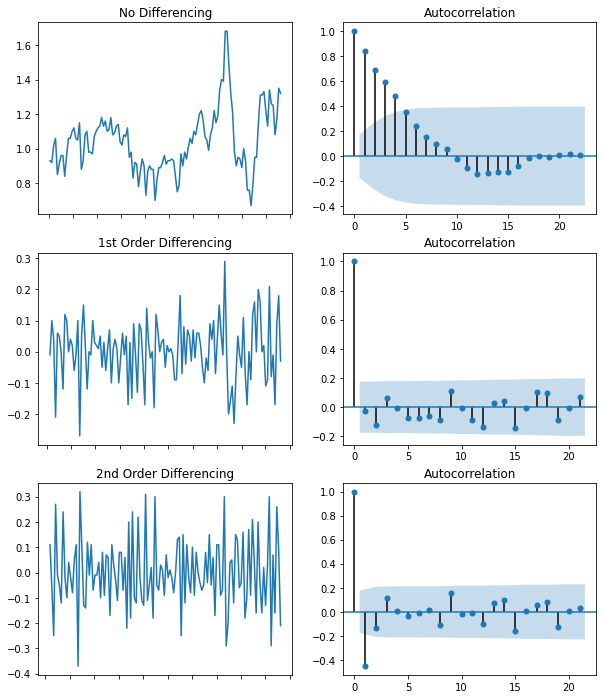

In [34]:
# No differencing
fig, axes = plt.subplots(3, 2, sharex=False, figsize=(10,12))
axes[0, 0].plot(arima_data[['AveragePrice']])
axes[0, 0].set_title('No Differencing')
axes[0, 0].set_xticklabels([])
plot_acf(arima_data[['AveragePrice']], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(arima_data[['AveragePrice']].diff())
axes[1, 0].set_title('1st Order Differencing')
axes[1, 0].set_xticklabels([])
plot_acf(arima_data[['AveragePrice']].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(arima_data[['AveragePrice']].diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
axes[2, 0].set_xticklabels([])
plot_acf(arima_data[['AveragePrice']].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In the plot above, the blue shaded area represents the 95% confidence interval of the region with no autocorrelation. In general:
- if the lag-1 autocorrelation is between -0.5 and 0, you have found a good choice for d.
- if the lag-1 autocorrelation is large and positive for several lags, you need to apply more differencing
- if the lag-1 autocorrelation is less than -0.5, you are int he over-differencing zone.

Based on these rules, `d=1` looks like the best option.

In [35]:
d = 1

differenced_data = arima_data[['AveragePrice']]
for i in range(d):
    differenced_data = differenced_data.diff().dropna()
print('Data has been differenced {} time(s)'.format(d))

Data has been differenced 1 time(s)


#### p  and q - lag order and moving average order

Most ARIMA models will make use of `p` (the number of previous timesteps to consider) or `q` (the size of the moving average window), but rarely both. Looking at the partial correlation plot for the chosen order of differencing will provide clues as to how to proceed:

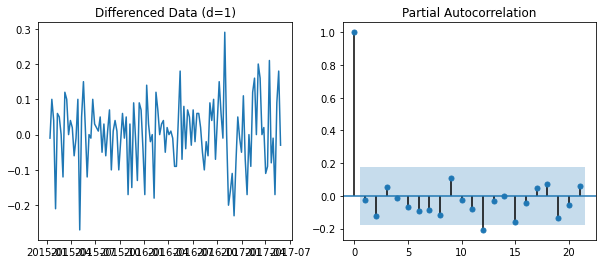

In [36]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].plot(differenced_data)
axes[0].set_title('Differenced Data (d={})'.format(d))
plot_pacf(differenced_data, ax=axes[1])
plt.show()

If the partial autocorrelation plot shows a significant drop-off (as we see above), then the `p` term should be adjusted while leaving `q=0`.

We can try fitting the ARIMA model for a few different values of `p` to see which gives the best result. In general, p is kept less than or equal to 2.

In [37]:
q = 0

In [39]:
for p in range(3):
    ar_model = ARIMA(arima_data['AveragePrice'], order=(p,d,q), dates=arima_data.index, freq='W')
    ar_fit = ar_model.fit(disp=0)
    predictions = ar_fit.predict(
                 start = len(train_data),
                 end = len(cali_data)-1,
                 typ='levels'
             )
    mse = mean_squared_error(predictions, test_data['AveragePrice'])
    print('For p = {0} the MSE is {1}'.format(p, round(mse,4)))   

For p = 0 the MSE is 0.0894
For p = 1 the MSE is 0.0897
For p = 2 the MSE is 0.0853


There is not a huge difference, but `p=2` gives the best results.

In [40]:
p = 2

#### Build ARIMA model

Now that the hyper parameters have been set, I can build the model:

In [41]:
arima_model = ARIMA(arima_data['AveragePrice'], order=(p,d,q), freq='W')
arima_fitted = arima_model.fit(disp=0)
#arima_fitted.summary()

In [42]:
forecasted, err, conf_int = list(arima_fitted.forecast(len(test_data), alpha=0.05))
arima_test_preds = pd.DataFrame({
    'prediction': forecasted,
    'date': test_data['Date'],
    'lower': conf_int[:,0],
    'upper': conf_int[:,1]
})

In [43]:
arima_mse = mean_squared_error(test_data['AveragePrice'], arima_test_preds['prediction'])
test_mse_comparison['ARIMA'] = round(arima_mse,4)

#### Results

The test set predictions are shown below, where the shaded region is the 95% confidence interval.

The ARIMA method does not work particularly well for this problem -- without introducing any seasonality, this is basically a linear regression model.

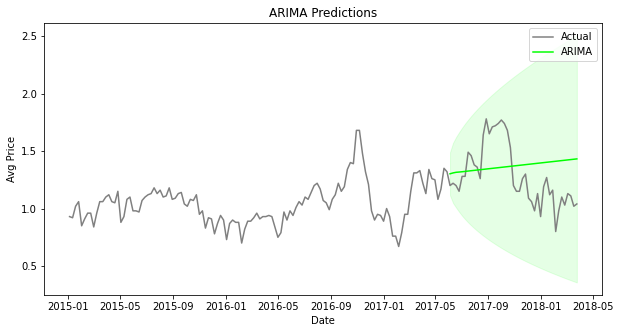

In [44]:
plt.figure(figsize=(10,5))
plt.plot(cali_data['Date'], cali_data['AveragePrice'], color='grey', label='Actual')
plt.plot(arima_test_preds['date'], arima_test_preds['prediction'], label='ARIMA', color='lime')
plt.fill_between(arima_test_preds['date'], arima_test_preds['lower'], arima_test_preds['upper'], color='lime', alpha=0.1)
plt.title('ARIMA Predictions')
plt.xlabel('Date')
plt.ylabel('Avg Price')
plt.legend()
ax.axvspan(CUTOFF_DATE, max(cali_data['Date']), alpha=0.2)
plt.show()

#### SARIMA

Earlier, I showed that the data has some sort of seasonality to it, where prices are more expensive in the winter. As such, a SARIMA model is probably more appropriate.

The SARIMA model takes in 4 additional parameters, related to the seasonal trends.
- `P` - Seasonal autoregressive order
- `Q` - Seasonal moving average order
- `D` - Seasonal difference order
- `m` - number of timesteps in a single seasonal period

Out of these parameters, `m` is the only intuitive one. Since our data is collected weekly and there are 52 weeks in a year, `m = 52`.

In [45]:
m = 52

If the timeseries shows some seasonal trends, then `D=1`. Otherwise, `D=0`.

In [46]:
D = 1

The training data only covers three full seasonal cycles (2015, 2016, 2017). As such, `P<=1` and `Q<=0`.

In [47]:
P=1
Q=0

#### Build SARIMA model

In [48]:
sarima_model = SARIMAX(
    arima_data['AveragePrice'],
    order=(p,d,q),
    seasonal_order=(P,D,Q,m),
    freq='W'
)
sarima_fit = sarima_model.fit()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


In [49]:
#sarima_predictions = sarima_fit.forecast(len(test_data))
sarima_fcast = sarima_fit.get_forecast(len(test_data))
sarima_predictions = sarima_fcast.predicted_mean
sarima_conf_int = sarima_fcast.conf_int()

In [50]:
sarima_mse = mean_squared_error(test_data['AveragePrice'], sarima_predictions)
test_mse_comparison['SARIMA'] = round(sarima_mse,4)

#### Results

The predictions are shown below, with the shaded region representing the 90% confidence interval. The SARIMA model outperforms the ARIMA model by capturing some seasonal trends. However, the region contained in the confidence interval is quite large, so the results are not that precise.

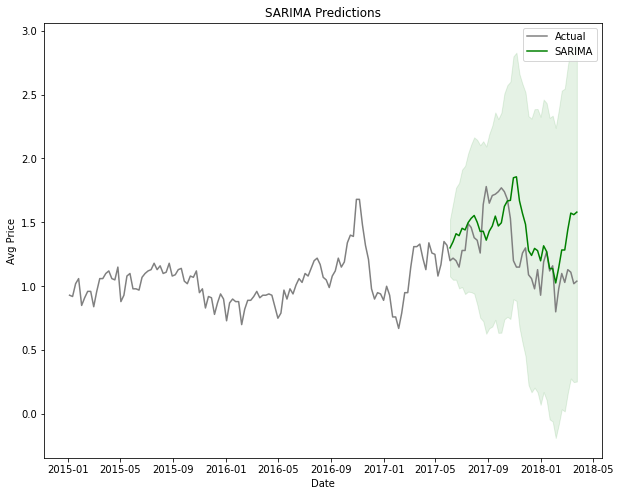

In [52]:
plt.figure(figsize=(10,8))

plt.plot(cali_data['Date'], cali_data['AveragePrice'], color='grey', label='Actual')
plt.plot(test_data['Date'], sarima_predictions, color='green', label='SARIMA')

plt.fill_between(
    test_data['Date'],
    sarima_conf_int['lower AveragePrice'],
    sarima_conf_int['upper AveragePrice'],
    color='green',
    alpha=0.1
)

plt.title('SARIMA Predictions')
plt.xlabel('Date')
plt.ylabel('Avg Price')
plt.legend()
plt.show()

### Method 3 - Prophet Package

Prophet is package released by Facebook used for making fast, automatic, and accurate timeseries predictions. It is robust and not sensitive to outliers. It tends to work best on timeseries datasets that show seasonal effects. More documentation cn be found here: https://facebook.github.io/prophet/

Prophet requires that your data be in a dataframe with column names `ds` (the timestamp) and `y` (the value to be predicted).

In [53]:
prophet_data = train_data[['Date', 'AveragePrice']].rename(columns = {
    'Date': 'ds', 'AveragePrice': 'y'
})
prophet_data.head()

,ds,y
0,2015-01-04,0.93
1,2015-01-11,0.92
2,2015-01-18,1.02
3,2015-01-25,1.06
4,2015-02-01,0.85


In [54]:
prophet_model = Prophet(interval_width=0.95)
prophet_model.fit(prophet_data)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [55]:
test_dates = test_data[['Date']].rename(columns={'Date':'ds'})

prophet_predictions = prophet_model.predict(test_dates)
prophet_predictions = prophet_predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [56]:
prophet_mse = mean_squared_error(test_data['AveragePrice'], prophet_predictions['yhat'])
test_mse_comparison['Prophet'] = round(prophet_mse,4)

#### Results

Prophet provides predictions along with upper and lower bounds.

The prophet model is able to capture the tredns quite well. It also has the advantage of being simple to train (whereas the S/ARIMA models were more time-consuming and subject to a significant amount of hyperparameter tuning).

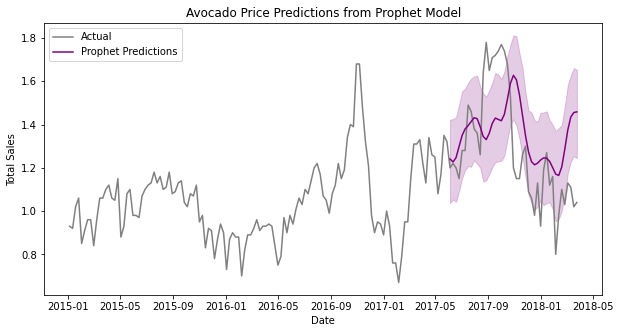

In [57]:
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(cali_data['Date'], cali_data['AveragePrice'], color='grey', label='Actual')
plt.plot(prophet_predictions['ds'], prophet_predictions['yhat'], color='purple', label='Prophet Predictions')

ax.fill_between(
    prophet_predictions['ds'],
    prophet_predictions['yhat_lower'],
    prophet_predictions['yhat_upper'],
    color='purple',
    alpha=0.2
)

plt.title('Avocado Price Predictions from Prophet Model')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

#### Method 4 - LSTM

Since we are dealing with timeseries data, a recurrent neural network is a good choice to use. Recurrent neural networks use sequential data as input and are able to predict future values. LSTM usually outperform other RNN models, so I will start with that.

At each timestep, the input data will be a vector containing the `TOTALSALES` previous values. `TIMESTEPS` is a hyperparameter that can be tuned; since we are dealing with a limited amount of data, which we know shows some seasonality, 52 is a good starting point.

The data can be scaled and reshaped to the proper input format for the RNN.

In [58]:
TIMESTEPS = 52

In [59]:
# reshape and scale data
train_set = np.array(train_data['AveragePrice']).reshape(len(train_data), 1)

sc = MinMaxScaler()
train_set_scaled = sc.fit_transform(train_set)

In [60]:
X_train = []
Y_train = []

for i in range(TIMESTEPS, len(train_set)):
    X_train.append(train_set_scaled[i-TIMESTEPS:i,0])
    Y_train.append(train_set_scaled[i,0])

X_train = np.array(X_train)
Y_train = np.array(Y_train)


X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#print(X_train.shape)
#print(Y_train.shape)

#### Build the model

The output of the model is the next value in the sequence (i.e., the AveragePrice for the next week). Predictions will be made one week at a time.

In [61]:
rnn = Sequential()

rnn.add(LSTM(
    units=50,
    activation = 'tanh',
    return_sequences = True,
    input_shape = (X_train.shape[1], X_train.shape[2])
))
rnn.add(Dropout(0.2))

rnn.add(LSTM(units=50, activation = 'tanh', return_sequences = False))
rnn.add(Dropout(0.2))
rnn.add(Dense(units=1))

In [62]:
rnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 52, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 52, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


Since the dataset is very small, the model can be trained quickly. I can also use a large number of epochs to get a fuller picture of whats going on.

In [63]:
N_EPOCH = 50
BATCH_SIZE = 8

In [64]:
rnn.compile(
    optimizer = 'adam',
    loss = 'mean_squared_error'
)

In [65]:
history = rnn.fit(
    X_train,
    Y_train,
    epochs = N_EPOCH,
    batch_size = BATCH_SIZE,
    verbose=False
)

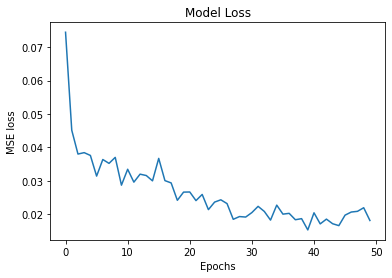

In [66]:
# plot the results
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE loss')
plt.show()

#### Predict

Now that the model is trained, compare the predictions on the test set to the actual prices.

In [67]:
combined_data = pd.concat([train_data, test_data])
combined_data = combined_data['AveragePrice']

In [68]:
inputs = combined_data[len(train_data)-TIMESTEPS:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)
print(inputs.shape)

(95, 1)


In [69]:
X_test = []
for i in range(TIMESTEPS, inputs.shape[0]):
    X_test.append(inputs[i-TIMESTEPS:i,0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(43, 52, 1)


In [70]:
predicted_test = rnn.predict(X_test)
predicted_test = sc.inverse_transform(predicted_test)

predicted_train = rnn.predict(X_train)
predicted_train = sc.inverse_transform(predicted_train)

In [71]:
rnn_predictions = np.concatenate([predicted_train, predicted_test])
rnn_dates = pd.concat([train_data['Date'][TIMESTEPS:], test_data['Date']])

In [72]:
lstm_mse = mean_squared_error(test_data['AveragePrice'], predicted_test)
test_mse_comparison['LSTM'] = round(lstm_mse,4)

#### Results

I haven't spent much time fine-tuning this model, but the initial results look quite promising. The model is able to capture the seasonal trends and the overall fit looks pretty good.

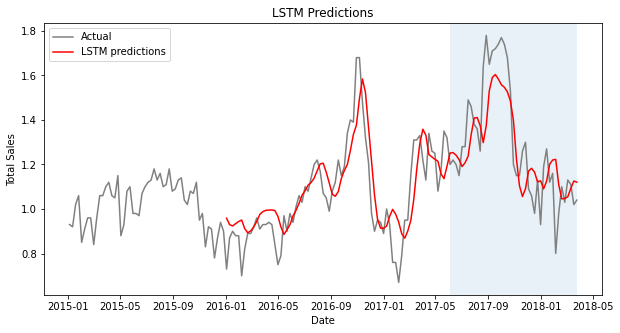

In [73]:
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(cali_data['Date'], cali_data['AveragePrice'], color='grey', label='Actual')
plt.plot(rnn_dates, rnn_predictions, color='red', label='LSTM predictions')


plt.title('LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
ax.axvspan(CUTOFF_DATE, max(cali_data['Date']), alpha=0.1)
plt.show()

### Model Comparison

To summarize the results for each model, I have shown all the predictions plotted on the same axes.

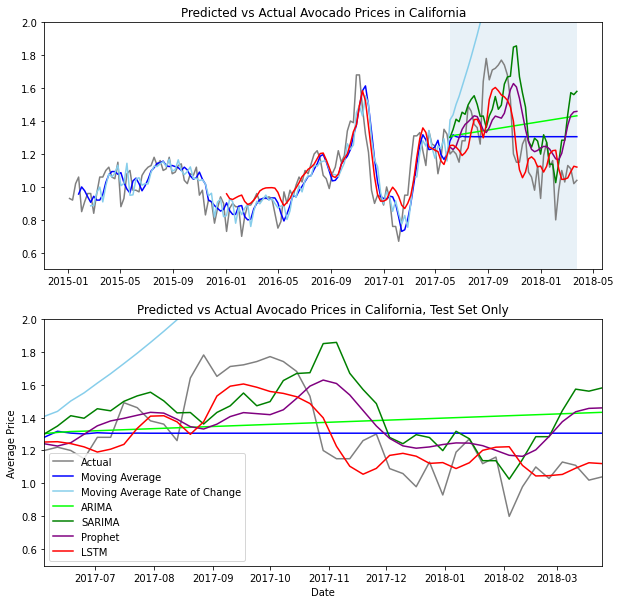

In [82]:
fig, ax = plt.subplots(2,1, figsize=(10,10))

for i in range(2):
    ax[i].plot(cali_data['Date'], cali_data['AveragePrice'], color='grey', label='Actual')
    ax[i].plot(ma_results['ts'], ma_results['y'], label='Moving Average', color='blue')    
    ax[i].plot(roc_results['ts'], roc_results['y'], label='Moving Average Rate of Change', color='skyblue')    
    ax[i].plot(arima_test_preds['date'], arima_test_preds['prediction'], label='ARIMA', color='lime')
    ax[i].plot(test_data['Date'], sarima_predictions, color='green', label='SARIMA')
    ax[i].plot(prophet_predictions['ds'], prophet_predictions['yhat'], color='purple', label='Prophet')
    ax[i].plot(rnn_dates, rnn_predictions, color='red', label='LSTM')
    ax[i].set_ylim(0.5,2)
    ax[i].set_ylabel('Average Price')

ax[0].set_title('Predicted vs Actual Avocado Prices in California')
ax[1].set_title('Predicted vs Actual Avocado Prices in California, Test Set Only')

ax.ylabel('Average Price')
    
ax[0].axvspan(CUTOFF_DATE, max(cali_data['Date']), alpha=0.1)
ax[1].set_xlim(min(test_data['Date']), max(test_data['Date']))

plt.ylabel('Average Price')
plt.xlabel('Date')
plt.legend()
plt.show()

The top plot shows the full time range (training and test set), while the bottom shows only the test set predictions.

#### MSE  Comparison

The LSTM model has the best performance (i.e., the lowest MSE). The second best model is Prophet.

In [78]:
test_mse_comparison.pop('Moving Average Rate of Change')

6.3864

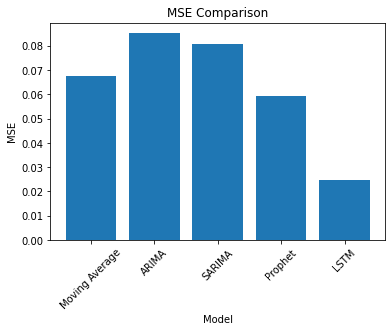

In [79]:
plt.bar(test_mse_comparison.keys(), test_mse_comparison.values())
plt.xticks(rotation=45)
plt.title('MSE Comparison')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.show()

## Conclusions

Although the LSTM model had the best performance, the Prophet model was by far the easiest to implement. Depending on time constraints, in some situations I might prefer to use Prophet.

In the future, if I revisit the project, I will try to spend more time fine-tuning the parameters for LSTM and (S)ARIMA models.

I am also curious to know if California proces can be predicted by looking at prices in other regions (e..g, can California prices be predicted from New York prices?).